## MDS Thesis
#### 05 Fine-tune the German ELECTRA model

<br>
<hr style="opacity: 0.5">

### Setup

In [1]:
# load libraries
import pandas as pd
import os
import torch

from transformers import ElectraTokenizer, ElectraModel
from datasets import Dataset

/Users/varvarailyina/miniconda3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check wd
os.getcwd()
#os.chdir("/Users/varvarailyina/hertie/mds_thesis/scripts/")

# load labels data
df_partypress = pd.read_csv("../data/in/partypress/csv/partypress.csv")

# load text data
df_texts = pd.read_csv("../data/in/partypress/csv/partypress_texts.csv")

In [3]:
# load tokenizer and model
tokenizer = ElectraTokenizer.from_pretrained('german-nlp-group/electra-base-german-uncased')
model = ElectraModel.from_pretrained('german-nlp-group/electra-base-german-uncased')

# set to evaluation mode
model.eval()

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(32767, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

<hr style="opacity: 0.5">

### Pre-process data

In [4]:
print(df_partypress.index.is_unique)
print(df_texts.index.is_unique)

True
True


In [5]:
# set merging index to be 'id'
df_partypress.set_index('id', inplace=True)
df_texts.set_index('id', inplace=True)

In [6]:
# merge datasets based on id and country_name
df = df_partypress.merge(df_texts, on=['id', 'country_name'], how='inner')

In [7]:
# check var names
print(df.columns)

Index(['country_name', 'parlgov_id', 'party', 'party_name',
       'party_name_english', 'family_name', 'date', 'month', 'month_start',
       'month_end', 'calendar_week', 'week_start', 'week_end', 'header',
       'issue_multi', 'issue_mono', 'issue', 'issue_coder2', 'position',
       'position_coder2', 'cv_sample', 'issue_ridge', 'issue_super', 'text'],
      dtype='object')


In [ ]:
# filter for germany
#df_de = df[df['country_name'] == 'germany']

# pre-process texts df
#texts = df_de['text'].dropna()
#text_df = texts.to_frame()

# convert df to dataset
#dataset = Dataset.from_pandas(text_df)

In [28]:
# filter for germany
df_de = df[df['country_name'] == 'germany']

# randomly select 100 press releases
df_sample = df_de.sample(n=100, random_state=42)

# pre-process texts df
texts = df_sample['text'].dropna()
text_df = texts.to_frame()

# convert df to dataset
dataset = Dataset.from_pandas(text_df)

In [25]:
df_de.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44950 entries, 18020 to 10366
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        44950 non-null  object 
 1   parlgov_id          44950 non-null  float64
 2   party               44950 non-null  object 
 3   party_name          44950 non-null  object 
 4   party_name_english  44950 non-null  object 
 5   family_name         44950 non-null  object 
 6   date                44950 non-null  object 
 7   month               44950 non-null  int64  
 8   month_start         44950 non-null  object 
 9   month_end           44950 non-null  object 
 10  calendar_week       44950 non-null  int64  
 11  week_start          44950 non-null  object 
 12  week_end            44950 non-null  object 
 13  header              44950 non-null  object 
 14  issue_multi         44950 non-null  int64  
 15  issue_mono          44950 non-null  int64  
 16  issue

In [9]:
# save as .csv
df_de.to_csv("../data/in/df_de.csv", index=False)

<hr style="opacity: 0.5">

### Tokenization and embeddings

-- *Tokenize data*

In [47]:
# keep index as id
df_sample.reset_index(inplace=True)
df_sample.rename(columns={'index': 'id'}, inplace=True)

print(df_sample.columns)

Index(['id', 'country_name', 'parlgov_id', 'party', 'party_name',
       'party_name_english', 'family_name', 'date', 'month', 'month_start',
       'month_end', 'calendar_week', 'week_start', 'week_end', 'header',
       'issue_multi', 'issue_mono', 'issue', 'issue_coder2', 'position',
       'position_coder2', 'cv_sample', 'issue_ridge', 'issue_super', 'text'],
      dtype='object')


In [48]:
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors='pt')

# Apply tokenization and keep 'id'
df_sample['tokenized_data'] = df_sample['text'].apply(tokenize_function)
df_sample['id'] = df_sample.index

In [29]:
## OG

# define function to tokenize data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512, return_tensors='pt')  # return_tensors='pt' for PyTorch

# run function
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 100/100 [00:00<00:00, 348.98 examples/s]


-- *Extract embeddings*

In [51]:
# define function to extract embeddings
def extract_embeddings(batch):
    # Ensure inputs are tensors; convert if necessary
    input_ids = torch.tensor(batch['input_ids'])
    attention_mask = torch.tensor(batch['attention_mask'])

    # forward pass, no gradient calculation
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # return embeddings; convert tensors to numpy arrays
    return {'embeddings': outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()}

# run function
embeddings = tokenized_dataset.map(extract_embeddings, batched=True)

Map: 100%|██████████| 100/100 [00:36<00:00,  2.72 examples/s]


In [ ]:
embeddings

In [52]:
all_embeddings = np.vstack([batch['embeddings'] for batch in embeddings])

In [53]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of embeddings to make them more manageable
pca = PCA(n_components=10)  # Reduce to 10 dimensions for simplicity and visualization
reduced_embeddings = pca.fit_transform(all_embeddings)

In [54]:
scores = np.linalg.norm(reduced_embeddings, axis=1)

# This scores array now represents a single score for each press release,
# indicating its intensity or radicalness based on the PCA-reduced embeddings.

In [55]:
# top scores
top_scores_indices = np.argsort(scores)[-10:]

print("Top 10 press releases based on intensity scores:")
print(top_scores_indices)

Top 10 press releases based on intensity scores:
[48 80 45 66 15 72 40 99 64 62]


In [64]:
# bottom scores
bottom_scores_indices = np.argsort(scores)[:10]

print(bottom_scores_indices)

[18 53 79  0 41 39 75 32 88 61]


In [65]:
# Ensure df_de is a DataFrame that corresponds in order to the embeddings
# Create a DataFrame from the scores to merge with df_de
scores_df = pd.DataFrame({
    'score': scores
}, index=df_sample.index)

# Combine the scores with the original DataFrame
df_de_with_scores = df_sample.join(scores_df)

# Filter for top scoring texts
df_top_scores = df_de_with_scores.loc[top_scores_indices]

# filter for bottom scoring text
df_bottom_scores = df_de_with_scores.loc[bottom_scores_indices]


#print(df_top_scores) 

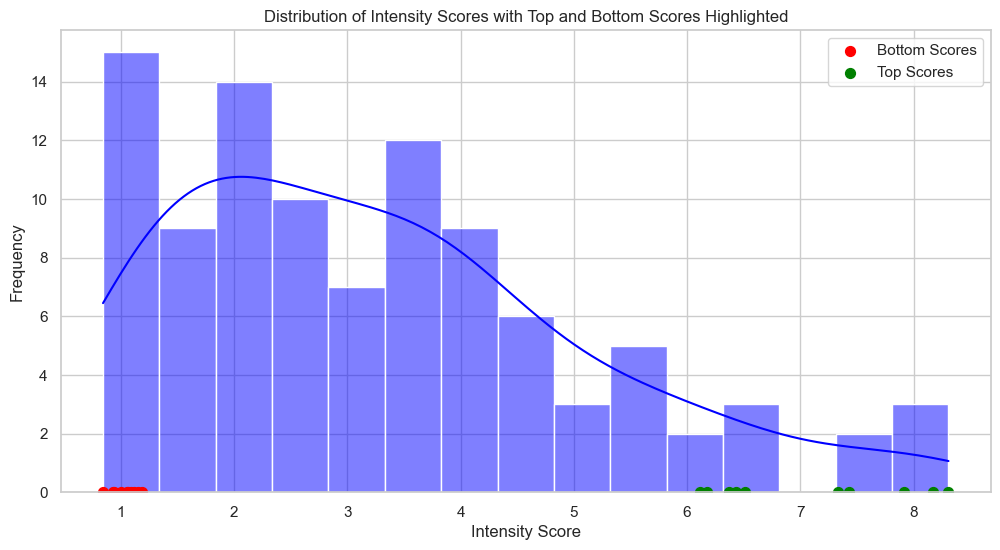

In [70]:
## visualize

import matplotlib.pyplot as plt
import seaborn as sns

# Setting style for seaborn plots
sns.set(style="whitegrid")

# Plotting the distribution of scores with emphasis on the top and bottom scores
plt.figure(figsize=(12, 6))
sns.histplot(df_de_with_scores['score'], kde=True, color="blue", binwidth=0.5)
plt.scatter(df_bottom_scores['score'], [0]*len(df_bottom_scores), color='red', s=50, label='Bottom Scores')
plt.scatter(df_de_with_scores.sort_values(by='score', ascending=False).head(10)['score'], [0]*10, color='green', s=50, label='Top Scores')
plt.title('Distribution of Intensity Scores with Top and Bottom Scores Highlighted')
plt.xlabel('Intensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

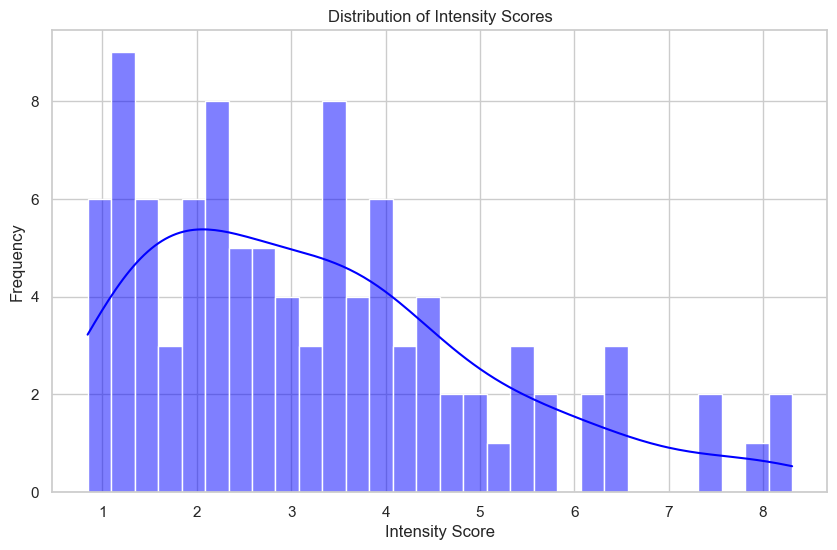

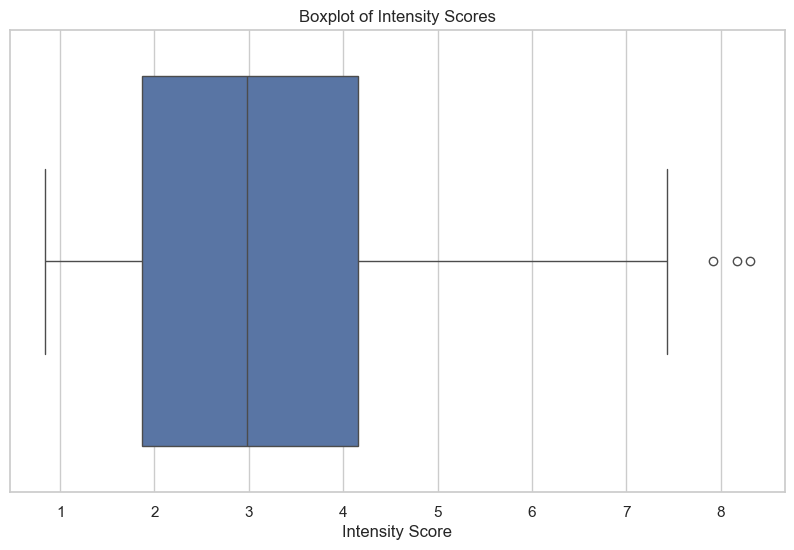

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting the distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=30, kde=True, color='blue')
plt.title('Distribution of Intensity Scores')
plt.xlabel('Intensity Score')
plt.ylabel('Frequency')
plt.show()

# Additionally, you might want to look at a boxplot to understand the spread and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=scores)
plt.title('Boxplot of Intensity Scores')
plt.xlabel('Intensity Score')
plt.show()

In [ ]:
## OLD

In [32]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Example: Your embeddings array
embeddings_array = np.array(embeddings)

# Reduce dimensions
pca = PCA(n_components=10)
reduced_embeddings = pca.fit_transform(embeddings_array)

# Apply clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Evaluate clustering quality
silhouette_avg = silhouette_score(reduced_embeddings, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Optional: Create a score based on distance to cluster centroid
distances = kmeans.transform(reduced_embeddings)
emotional_intensity_score = distances.min(axis=1)

TypeError: float() argument must be a string or a real number, not 'dict'